# GPT4 Zero-Shot Modeling for Software Citation Intent Prediction

In this notebok, we showcase an example of using a GPT4 model in a zero-shot setting for predicting software citation intent.
Note that running this notebook requires access to an OpenAI API key, which can be retrieved from the OpenAI API website: https://openai.com/product#made-for-developers

In [1]:
import pandas as pd
import os
from openai import OpenAI
# your OpenAI key goes here
OPENAI_API_KEY = ""
client = OpenAI(api_key = OPENAI_API_KEY)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
import plotly.express as px
import warnings
import time
from collections import Counter
warnings.simplefilter("ignore")

## Data Reading
The data used for training and testing has the following fields:
- **id**: paper_id (e.g. PMC id)
- **sentence**: sentence containing the software mention
- **used**: True if the intent of the software mentioned in the sentence is usage
- **created**: True if the intent of the software mentioned in the sentence is creation
- **mention**: True if the intent of the software mentioned in the sentence is mentioned
- **context**: context around the sentence, if available; this would be the leading and trailing sentence in the paragraph around the sentence
- **label**: categorical label; not that a sentence can only have one label
- **text**: same as sentence

In [2]:
data_df = pd.read_csv('../data/software_citation_intent_merged.csv')
LABEL2TEXT = {0 : 'creation', 1 : 'usage', 2 : 'mention', 3: 'none'}

In [3]:
data_df.head()

,Unnamed: 0,id,sentence,used,created,mention,context,label,text
0,0,PMC5189946,All of this analysis was implemented using Mat...,False,True,False,NaN,0,All of this analysis was implemented using Mat...
1,1,PMC4511233,"Code for calculating partition similarity, obt...",False,True,False,Since the probability of getting a given MI is...,0,"Code for calculating partition similarity, obt..."
2,2,PMC4186879,All behavioral statistical analyses were perfo...,False,False,True,All behavioral statistical analyses were perfo...,2,All behavioral statistical analyses were perfo...
3,3,PMC5026371,"M-Track was written using Python 2.7, OpenCV 3...",True,False,False,NaN,1,"M-Track was written using Python 2.7, OpenCV 3..."
4,4,PMC1283974,"Mindboggle is a freely downloadable, open sour...",False,True,False,"Mindboggle is a freely downloadable, open sour...",0,"Mindboggle is a freely downloadable, open sour..."


The data has been split into train and test, where test is used for validation. Note that in a zero-shot setting, we don't use the training split at all, and only test performance on the test split.

In [4]:
X_train_df = pd.read_csv('../data/gpt3.5_formatted_data/gpt3.5_train.csv')
X_test_df = pd.read_csv('../data/gpt3.5_formatted_data/gpt3.5_test.csv')
X_test_df['label_descriptive'] = X_test_df['label'].apply(lambda x: LABEL2TEXT[x])

In [5]:
X_train_df.head()

,Unnamed: 0,id,sentence,used,created,mention,context,label,text,label_descriptive
0,2874,PMC5591006,Based on a structural support vector machine (...,False,False,True,The phylogenetic affiliation of the fosmid ins...,2,Based on a structural support vector machine (...,mention
1,383,PMC5540584,Visual and auditory stimuli were presented usi...,True,False,False,Visual and auditory stimuli were presented usi...,1,Visual and auditory stimuli were presented usi...,usage
2,2046,PMC5690316,The very first strip chart (A) illustrates the...,True,False,False,Because the Ki67 data are skewed with a large ...,1,The very first strip chart (A) illustrates the...,usage
3,1380,PMC6267992,We use Stata’s margins command to calculate pr...,True,False,False,NaN,1,We use Stata’s margins command to calculate pr...,usage
4,841,PMC4847873,Selected variants in Family A were tested for ...,True,False,False,Selected variants in Family A were tested for ...,1,Selected variants in Family A were tested for ...,usage


In [6]:
len(X_train_df), len(X_test_df), len(data_df)

(3350, 838, 4188)

## Zero-shot GPT model

In [7]:
def query_gpt(message, model):
    completion = client.chat.completions.create(model=model, messages=message)
    predicted_class = completion.choices[0].message.content.lower().strip()
    return predicted_class

def print_statement(i, print_every, verbose, sentence = None, predicted_class = None, label = None):
    if i % print_every == 0:
        if not verbose:
            print('Predicting on sentence', str(i))
        else:
            print(i, 'Sentence: ', sentence, '\nPredicted class:', predicted_class, 'Real class:' + label + '\n\n')

def predict_gpt(sentences, y_test, model, print_every = 10, verbose = False):
    initial_message = [{"role": "system", 
                "content": "You are a scientist trying to figure out the citation intent behind software mentioned in sentences coming from research articles. Your four categories are: creation, usage, mention, or none. The definitions of the classes are: \
                - creation: software was created by the authors of the paper \
                - usage: software was used in the paper \
                - mention: software was mentioned in the paper, but not used, nor created \
                - none: none of the previous 3 categories apply \
                You need to output one category only."}]
    predicted_labels = []
    true_labels = []
    indices = range(len(sentences))
    completed_sentences = []
    for i, sentence, label in zip(indices, sentences, y_test):
        message = initial_message + [{"role": "user", "content": "Sentence: " + sentence.strip() + '.'}]      
        try:
            predicted_class = query_gpt(message, model)
            print_statement(i, print_every, verbose, sentence, predicted_class, label)
            predicted_labels.append(predicted_class)
            true_labels.append(label)
            completed_sentences.append(sentence)
        except:
            print('got an error')
            continue
    return predicted_labels, true_labels, completed_sentences

## Evaluation

In [8]:
def evaluate(true_labels, predicted_labels):
    p, r, f1, support = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
    accuracy = round(accuracy_score(true_labels, predicted_labels), 3)
    print('Precision: ', round(p, 3), 'Recall: ', round(r, 3), 'F1:', round(f1, 3), 'Accuracy:', accuracy)
    print(classification_report(true_labels, predicted_labels, labels = list(LABEL2TEXT.values())))

#### Test split

In [9]:
test_sentences = X_test_df['sentence'].to_list()
y_test_true = X_test_df['label_descriptive'].to_list()
print('Predicting on', len(X_test_df), 'sentences')

Predicting on 838 sentences


In [10]:
# note that we use y_test_pred_completed and y_test_true_completed because some sentences will come back from an error when calling the OpenAI API, so we only want to compute the metrics on the sentences we actually completed
y_test_pred_completed, y_test_true_completed, test_completed_sentences = predict_gpt(test_sentences, y_test_true, "gpt-4", print_every = 1)

Predicting on sentence 0
Predicting on sentence 1
Predicting on sentence 2
Predicting on sentence 3
Predicting on sentence 4
Predicting on sentence 5
Predicting on sentence 6
Predicting on sentence 7
Predicting on sentence 8
Predicting on sentence 9
Predicting on sentence 10
Predicting on sentence 11
Predicting on sentence 12
Predicting on sentence 13
Predicting on sentence 14
Predicting on sentence 15
Predicting on sentence 16
Predicting on sentence 17
Predicting on sentence 18
Predicting on sentence 19
Predicting on sentence 20
Predicting on sentence 21
Predicting on sentence 22
Predicting on sentence 23
Predicting on sentence 24
Predicting on sentence 25
Predicting on sentence 26
Predicting on sentence 27
Predicting on sentence 28
Predicting on sentence 29
Predicting on sentence 30
Predicting on sentence 31
Predicting on sentence 32
Predicting on sentence 33
Predicting on sentence 34
Predicting on sentence 35
Predicting on sentence 36
Predicting on sentence 37
Predicting on sentence

In [11]:
print('Finished', len(y_test_true_completed), 'sentences out of', len(X_test_df))
evaluate(y_test_true_completed, y_test_pred_completed)

Finished 838 sentences out of 838
Precision:  0.684 Recall:  0.662 F1: 0.664 Accuracy: 0.815
              precision    recall  f1-score   support

    creation       0.73      0.70      0.71        94
       usage       0.83      0.96      0.89       449
     mention       0.26      0.11      0.15        95
        none       0.92      0.88      0.90       200

    accuracy                           0.82       838
   macro avg       0.68      0.66      0.66       838
weighted avg       0.78      0.82      0.79       838



In [12]:
Counter(y_test_true_completed)

Counter({'usage': 449, 'none': 200, 'mention': 95, 'creation': 94})

#### CZI validation dataset

In [13]:
czi_val_df = pd.read_csv('../data/czi_val_merged.csv').drop_duplicates()
czi_val_df['label'] = czi_val_df['label'].apply(lambda x: 'mention' if x == 'none' else x)
test_sentences_czi = czi_val_df['text'].to_list()
y_czi_val = czi_val_df['label'].to_list()
y_pred_completed_czi, y_true_completed_czi, test_completed_sentences_czi = predict_gpt(test_sentences_czi, y_czi_val, "gpt-3.5-turbo", print_every = 1)

Predicting on sentence 0
Predicting on sentence 1
Predicting on sentence 2
Predicting on sentence 3
Predicting on sentence 4
Predicting on sentence 5
Predicting on sentence 6
Predicting on sentence 7
Predicting on sentence 8
Predicting on sentence 9
Predicting on sentence 10
Predicting on sentence 11
Predicting on sentence 12
Predicting on sentence 13
Predicting on sentence 14
Predicting on sentence 15
Predicting on sentence 16
Predicting on sentence 17
Predicting on sentence 18
Predicting on sentence 19
Predicting on sentence 20
Predicting on sentence 21
Predicting on sentence 22
Predicting on sentence 23
Predicting on sentence 24
Predicting on sentence 25
Predicting on sentence 26
Predicting on sentence 27
Predicting on sentence 28
Predicting on sentence 29
Predicting on sentence 30
Predicting on sentence 31
Predicting on sentence 32
Predicting on sentence 33
Predicting on sentence 34
Predicting on sentence 35
Predicting on sentence 36
Predicting on sentence 37
Predicting on sentence

In [14]:
print('Completed', len(test_completed_sentences_czi), '/', len(test_sentences_czi))
evaluate(y_true_completed_czi, y_pred_completed_czi)

Completed 210 / 210
Precision:  0.473 Recall:  0.544 F1: 0.495 Accuracy: 0.8
              precision    recall  f1-score   support

    creation       0.58      0.70      0.64        10
       usage       0.96      0.82      0.89       177
     mention       0.35      0.65      0.45        23
        none       0.00      0.00      0.00         0

    accuracy                           0.80       210
   macro avg       0.47      0.54      0.49       210
weighted avg       0.88      0.80      0.83       210



### Error Analysis

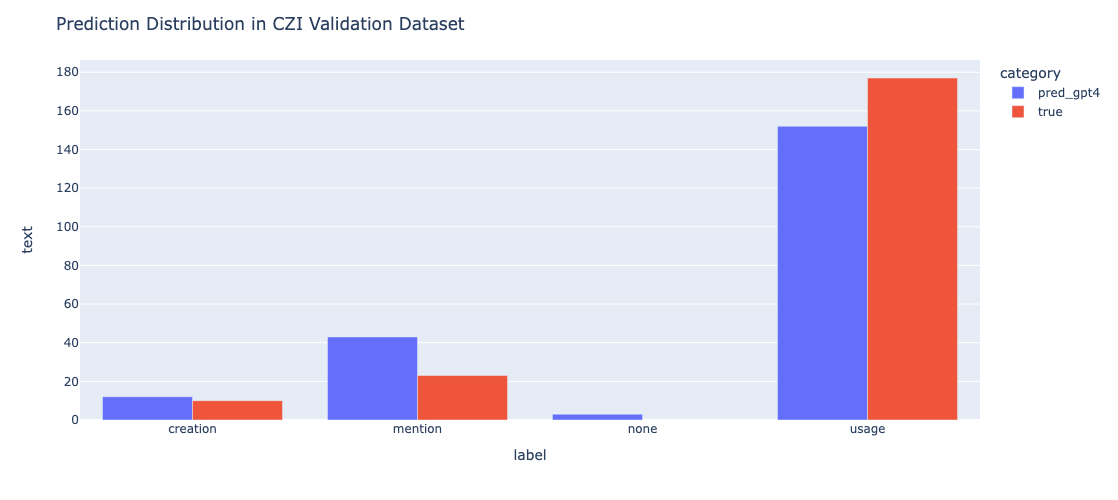

In [19]:
def get_pred_label(x, completed_sentences, y_pred_completed):
    for sent, label in zip(completed_sentences, y_pred_completed):
        if sent == x:
            return label
    return 'no_prediction'

czi_val_df['category'] = 'true'
czi_val_df['pred_label'] = czi_val_df['text'].apply(lambda x: get_pred_label(x, test_completed_sentences_czi, y_pred_completed_czi))
czi_val_df_pred = czi_val_df.copy()
czi_val_df_pred['category'] = 'pred_gpt4'
czi_val_df_pred['label'] = czi_val_df_pred['pred_label']

czi_val_df_all = pd.concat([czi_val_df_pred, czi_val_df])

labels_grouped = czi_val_df_all.groupby(['label', 'category']).count().reset_index()
fig = px.bar(labels_grouped, x = 'label', y = 'text', color = 'category', barmode = 'group')
fig.update_layout(width=800,height=500, title = 'Prediction Distribution in CZI Validation Dataset')

#### False positives

In [16]:
pd.set_option('display.max_colwidth', 1000)
czi_val_df[(czi_val_df['pred_label'] == 'mention') & (czi_val_df['label'] != 'mention')]

,doi_link,source,text,software,intent,label,category,pred_label
1,https://doi.org/10.1155/2014/395212,5. Simulation Results and Analysis,"In Figure 11, p miss of SVM-SMP is nearly equal to 0, which is much better than SVM-LA",SVM,used,usage,true,mention
8,https://doi.org/10.1371/journal.pone.0126783,Mapping of high expressed unigenes on MapMan pathways.,The genes exhibiting high expression (≥100 normalized RPKM values) were mapped on functional bins assigned to different pathways in MapMan,MapMan,used,usage,true,mention
11,https://doi.org/10.1371/journal.pone.0170378,Species data and frequency-based analyses,This was performed with the 'raster' and 'spatstat' packages in R software [37],raster,used,usage,true,mention
12,https://doi.org/10.7554/eLife.05005,Collection and processing of previous predictions,"For algorithms providing multiple transcript-level predictions (i.e., miRanda-MicroCosm, PACCMIT-CDS, and TargetSpy), the transcript with the best score was selected as the representative transcript isoform",TargetSpy,used,usage,true,mention
19,https://doi.org/10.3389/fonc.2021.684984,Statistical Analysis,"Data from this study were processed with GraphPad Prism 8 (GraphPad Software, USA) and expressed as mean ± standard deviation (x ± s)",GraphPad Prism,used,usage,true,mention
21,https://doi.org/10.3389/fphar.2017.00726,Quantitative PCR,Relative expression levels and significance were determined using the ΔΔCt method and presented after analysis by GraphPad Prism 6,GraphPad Prism,used,usage,true,mention
33,https://doi.org/10.1186/s13059-019-1634-2,fig_caption,"NCBoost scores offered the highest within-individual rank percentiles of pathogenic variants (median 97.04%), with a statistical significant difference (one-sided paired Wilcoxon test p value) as compared to all evaluated reference methods: ReMM (median 96.34%; p value = 3.75e−2), Eigen (median 96.00%, p value = 9.55e−2), DeepSEA (95.3%; p value = 1.96e−3), CADD (median 93.50; p value = 4.03e−3), FunSeq2 (median 89.92; p value = 5.88e−4)",CADD,used,usage,true,mention
45,https://doi.org/10.1186/s12864-017-3775-6,fig_caption,b Histogram presentation of functional categories (as annotated in Vectorbase) of upregulated (Up) and downregulated (Down) DE genes shared between SM and PM samples at 1 dpf,Vectorbase,used,usage,true,mention
52,https://doi.org/10.3389/fgene.2020.00462,NaN,Isoforms distribution of control (A) and cold-treated (B) wheat leaves in CIRCOS visualization,CIRCOS,used,usage,true,mention
60,https://doi.org/10.1186/1476-4598-8-42,Characterisation of the human RASSF10 gene,That the predicted N-terminal 108 amino acids may not actually be part of the RASSF10 protein is supported by ClustalW alignments of RASSF7–10,ClustalW,used,usage,true,mention


#### False negatives

In [17]:
czi_val_df[(czi_val_df['label'] == 'usage') & (czi_val_df['pred_label'] != 'usage')]

,doi_link,source,text,software,intent,label,category,pred_label
1,https://doi.org/10.1155/2014/395212,5. Simulation Results and Analysis,"In Figure 11, p miss of SVM-SMP is nearly equal to 0, which is much better than SVM-LA",SVM,used,usage,true,mention
2,https://doi.org/10.3389/fphys.2020.587057,Network Architecture and Training Parameters,A pattern recognition network was created using MATLAB r2017b to study the performance of the extracted gait parameters,MATLAB,used,usage,true,creation
4,https://doi.org/10.7717/peerj.9470,Conclusions,"The GitHub repository for this study has been created, including the Python scripts and the datasets used in this study (see https://github.com/smiile8888/rna-splice-sites-recognition)",Python,used,usage,true,creation
8,https://doi.org/10.1371/journal.pone.0126783,Mapping of high expressed unigenes on MapMan pathways.,The genes exhibiting high expression (≥100 normalized RPKM values) were mapped on functional bins assigned to different pathways in MapMan,MapMan,used,usage,true,mention
11,https://doi.org/10.1371/journal.pone.0170378,Species data and frequency-based analyses,This was performed with the 'raster' and 'spatstat' packages in R software [37],raster,used,usage,true,mention
12,https://doi.org/10.7554/eLife.05005,Collection and processing of previous predictions,"For algorithms providing multiple transcript-level predictions (i.e., miRanda-MicroCosm, PACCMIT-CDS, and TargetSpy), the transcript with the best score was selected as the representative transcript isoform",TargetSpy,used,usage,true,mention
19,https://doi.org/10.3389/fonc.2021.684984,Statistical Analysis,"Data from this study were processed with GraphPad Prism 8 (GraphPad Software, USA) and expressed as mean ± standard deviation (x ± s)",GraphPad Prism,used,usage,true,mention
21,https://doi.org/10.3389/fphar.2017.00726,Quantitative PCR,Relative expression levels and significance were determined using the ΔΔCt method and presented after analysis by GraphPad Prism 6,GraphPad Prism,used,usage,true,mention
25,https://doi.org/10.1186/s13031-021-00356-7,Complex emergencies,"Maps showing the location of event types were created in ArcGIS 10.7 (ESRI, Redlands, CA)",ArcGIS,used,usage,true,creation
30,https://doi.org/10.1186/s13021-019-0117-9,Development of the lidar biomass estimator,"We then developed a lidar-derived AGB model using the nonlinear least squares “nls” function in R [24], based on a total of 43 1 ha plots (15 real 1 ha plots, and 28 aggregated ones, Additional file 1: Table S1)",R,used,usage,true,creation


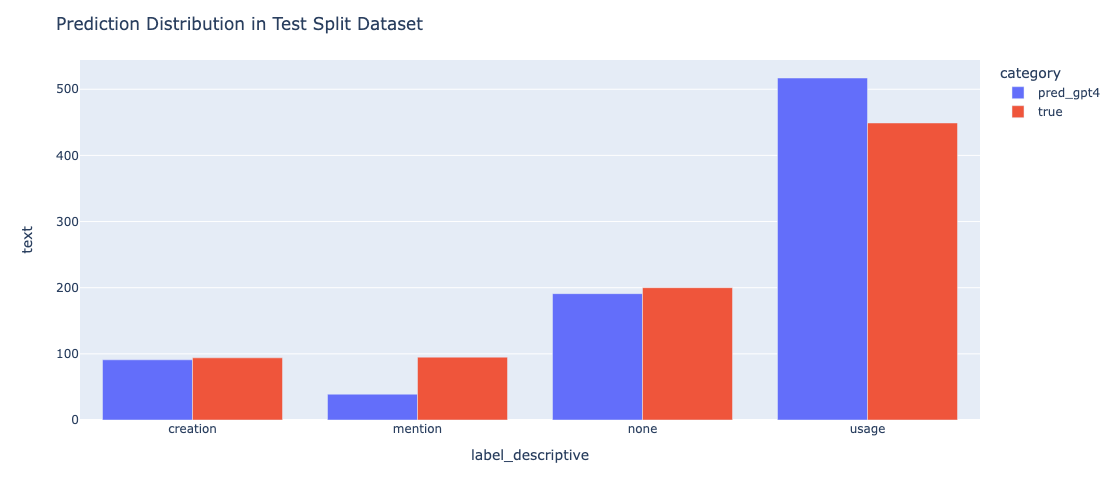

In [20]:
X_test_df['category'] = 'true'
X_test_df['pred_label'] = X_test_df['text'].apply(lambda x: get_pred_label(x, test_completed_sentences, y_test_pred_completed))
X_test_df_pred = X_test_df.copy()
X_test_df_pred['category'] = 'pred_gpt4'
X_test_df_pred['label_descriptive'] = X_test_df_pred['pred_label']

X_test_df_all = pd.concat([X_test_df_pred, X_test_df])

labels_grouped = X_test_df_all.groupby(['label_descriptive', 'category']).count().reset_index()
fig = px.bar(labels_grouped, x = 'label_descriptive', y = 'text', color = 'category', barmode = 'group')
fig.update_layout(width=800,height=500, title = 'Prediction Distribution in Test Split Dataset')